# Homework 3
You will use the PyTorch library for all the classes and methods in this assignment. You should use a double-precision data type, and the device is either "CPU" or "cuda."

In [1]:
import torch
import pandas as pd
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, MinMaxScaler
from sklearn.metrics import mean_squared_error
from scipy.linalg import toeplitz

In [2]:
# importing classes
import SCAD_Class as SCAD
import Elastic_Net_Class as EN
import SQRT_Lasso_Class as SQRT

## Part 1
1) Create your own PyTorch class that implements the method of SCAD regularization and variable selection (smoothly clipped absolute deviations) for linear models. Your development should be based on the following references:

- https://andrewcharlesjones.github.io/journal/scad.html
- https://www.jstor.org/stable/27640214?seq=1

 Test your method on a real data set and determine a variable selection based on features' importance, according to SCAD. (4 points)

In [3]:
# importing housing dataset from github
housing = pd.read_csv('https://raw.githubusercontent.com/dvasiliu/AML/refs/heads/main/Data%20Sets/housing.csv')
housing = housing.drop(columns = ['town', 'tract','longitude','latitude','river','highway']) # removing categorical/string features
housing.head(2)

,crime,residential,industrial,nox,rooms,older,distance,tax,ptratio,lstat,cmedv
0,0.00632,18.0,2.31,0.538,6.575,65.199997,4.0900,296,15.300000,4.98,24.0
1,0.02731,0.0,7.07,0.469,6.421,78.900002,4.9671,242,17.799999,9.14,21.6


In [4]:
# setting x and y variables with y being CMEDV which is Median value of owner-occupied homes in $1000's
X = housing.drop(columns=['cmedv'])
y = housing['cmedv']

#scaling the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# turning inputs for x and y into tensors
X_tensor = torch.tensor(X_scaled, dtype=torch.float64)
y_tensor = torch.tensor(y.values, dtype=torch.float64)

In [5]:
# performing tts on data
X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=440)

In [45]:
#setting a random seed so results are reproducible
torch.manual_seed(440)

# initializing the SCADLinearRegression model from .py file
model = SCAD.SCADLinearRegression(input_size=X_train.shape[1], lambda_val=.01, a_val=2.5)

#fitting the model
model.fit(X_train, y_train)

# getting the coefficients learned by the model after training
coefficients = model.get_coefficients().detach().cpu().numpy()
print("Coefficients:", coefficients)

# making predictions on the test set (X_test)
predictions = model.predict(X_test)
#print("Predictions:", predictions)

epoch: 100/2000, loss_with_scad: 376.60782296041083
epoch: 200/2000, loss_with_scad: 259.5646985991106
epoch: 300/2000, loss_with_scad: 182.38856727025606
epoch: 400/2000, loss_with_scad: 130.67971430703227
epoch: 500/2000, loss_with_scad: 95.91156986636331
epoch: 600/2000, loss_with_scad: 72.50186291611897
epoch: 700/2000, loss_with_scad: 56.72116130703257
epoch: 800/2000, loss_with_scad: 46.06801615811814
epoch: 900/2000, loss_with_scad: 38.86306559088702
epoch: 1000/2000, loss_with_scad: 33.978414146320226
epoch: 1100/2000, loss_with_scad: 30.65629639221519
epoch: 1200/2000, loss_with_scad: 28.38743754211489
epoch: 1300/2000, loss_with_scad: 26.829429880099394
epoch: 1400/2000, loss_with_scad: 25.75194870353892
epoch: 1500/2000, loss_with_scad: 24.999974793544578
epoch: 1600/2000, loss_with_scad: 24.469099781433883
epoch: 1700/2000, loss_with_scad: 24.088941028486783
epoch: 1800/2000, loss_with_scad: 23.812000311306516
epoch: 1900/2000, loss_with_scad: 23.606177588318417
epoch: 2000

### Findings

The coefficients as found above rounded: 
- crime:&nbsp;&nbsp; -2.780
- residential:&nbsp;&nbsp;   9.146	
- industrial:&nbsp;&nbsp;   -0.640	
- nox:&nbsp;&nbsp;   1.536
- rooms:&nbsp;&nbsp;   26.372	
- older:&nbsp;&nbsp;   7.703
- distance:&nbsp;&nbsp;   10.825	
- tax:&nbsp;&nbsp;   -4.446 	
- ptratio:&nbsp;&nbsp;   4.774	
- lstat:&nbsp;&nbsp;   -6.621

The positive coefficients indicate that an increase in the feature corresponds to an increase in predicted median home value (ex. as residential increases (proportion of residential land zoned for large lots), so does predicted median home value).

The negative coefficients indicate than an increase in the feature corresponds to a decrease in predicted median home value (ex. as tax increases (full-value property-tax rate per $10,000), predicted median home value decreases).

Based on these coefficients, we can determine that tax, ptratio, and is not a useful variable in predicting median home value. We can also determine that residential, rooms, older, and distance are all very significant variables in predicting median home value and should therefore stay in our model.

## Part 2

Based on the simulation design explained in class, generate 200 data sets where the input features have a strong correlation structure (you may consider a 0.9) and apply ElasticNet, SqrtLasso and SCAD to check which method produces the best approximation of an ideal solution, such as a "betastar" you design with a sparsity pattern of your choice.

### Code

In [7]:
# Generating 200 data sets where inputs have correlation of .9, this code is based on Penalized Regression with PyTorch notebook example.
def make_correlated_features(num_samples,p,rho):
  vcor = []
  for i in range(p):
    vcor.append(rho**i)
  r = toeplitz(vcor)
  mu = np.repeat(0,p)
  x = np.random.multivariate_normal(mu, r, size=num_samples)
  return x

rho =0.9 # correlation
p = 7 # number of features
n = 200 # number of samples
vcor = []
for i in range(p):
  vcor.append(rho**i)


x = make_correlated_features(n,p,rho)

In [8]:
beta =np.array([-1,0,0,2,2,-3])
beta = beta.reshape(-1,1)
betastar = np.concatenate([beta,np.repeat(0,p-len(beta)).reshape(-1,1)],axis=0)
y = x@betastar + 1.5*np.random.normal(size=(n,1))

In [9]:
x_tensor = torch.tensor(x, dtype=torch.float64)
y_tensor = torch.tensor(y, dtype=torch.float64)

y_tensor_scad = torch.tensor(y, dtype=torch.float64).flatten()

In [10]:
elastic_net = EN.ElasticNet(input_size=p, alpha=0.1, l1_ratio=0.5)
elastic_net.fit(x_tensor, y_tensor)
learned_coefficients_el = elastic_net.get_coefficients().detach().numpy().flatten()

sqrt_lasso = SQRT.SqrtLasso(input_size=p, alpha = .1)
sqrt_lasso.fit(x_tensor, y_tensor)
learned_coefficients_sl = sqrt_lasso.get_coefficients().detach().numpy().flatten() 

scad_model = SCAD.SCADLinearRegression(input_size=p, lambda_val=.01, a_val=2.5)
scad_model.fit(x_tensor, y_tensor, num_epochs=1000, learning_rate=.001)
learned_coefficients_scad = scad_model.get_coefficients().detach().numpy().flatten()

Epoch [100/1000], Loss: 2.041406786620891
Epoch [200/1000], Loss: 1.9238492069236317
Epoch [300/1000], Loss: 1.851661909850937
Epoch [400/1000], Loss: 1.804956424836439
Epoch [500/1000], Loss: 1.7736272152329782
Epoch [600/1000], Loss: 1.7519380402921791
Epoch [700/1000], Loss: 1.7364888290278198
Epoch [800/1000], Loss: 1.7252073995403505
Epoch [900/1000], Loss: 1.7167963890152793
Epoch [1000/1000], Loss: 1.710419671793496
Epoch [100/1000], Loss: 2.0990521013976564
Epoch [200/1000], Loss: 2.082826640590181
Epoch [300/1000], Loss: 2.0799512647531984
Epoch [400/1000], Loss: 2.079817882996429
Epoch [500/1000], Loss: 2.0797049758388537
Epoch [600/1000], Loss: 2.0798684071040263
Epoch [700/1000], Loss: 2.0797041280006634
Epoch [800/1000], Loss: 2.079776758948655
Epoch [900/1000], Loss: 2.0797184519341694
Epoch [1000/1000], Loss: 2.0796732275117145


In [11]:
coef_data = {
    "True Coefficients": betastar.flatten(),
    "ElasticNet Coefficients": learned_coefficients_el,
    "SqrtLasso Coefficients": learned_coefficients_sl,
    "SCAD Coefficients": learned_coefficients_scad
}

df = pd.DataFrame(coef_data)
pd.set_option('display.float_format', '{:.4f}'.format)
df

,True Coefficients,ElasticNet Coefficients,SqrtLasso Coefficients,SCAD Coefficients
0,-1,-0.6635,-0.3079,-0.3240
1,0,-0.0365,0.0009,0.2648
2,0,0.4284,0.0045,0.0810
3,2,1.1900,1.2467,0.3324
4,2,0.9424,0.6208,-0.1565
5,-3,-1.0423,-1.0641,-0.0684
6,0,-0.4214,-0.0120,0.0250


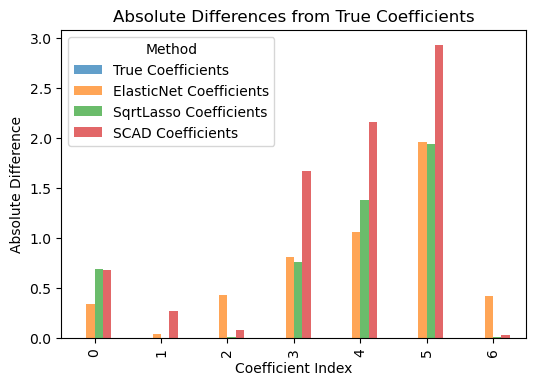

In [12]:
# Calculate absolute differences
abs_diff = df.sub(df["True Coefficients"], axis=0).abs()
abs_diff.plot(kind='bar', figsize=(6, 4), alpha=0.7)
plt.title("Absolute Differences from True Coefficients")
plt.ylabel("Absolute Difference")
plt.xlabel("Coefficient Index")
plt.legend(title="Method")
plt.show()

### Findings

The ElasticNet and Square Root Lasso coefficients at indecies 1, 2, and 6 are very close to the true value. These are also the indecies where the coefficient should be zero. These two methods seem to be very close in their coefficient estimations with some major deviations from the correct coefficient.

The SCAD method is consistently off in its approximations of the coefficients. It did perform better than the other two methods on indecies 0, 3, 4, and 6 (where the coefficient was non-zero); however, there were still sigficant deviations from the true value. 

## Part 3
Use the methods you implemented above to determine a variable selection for the Concrete data set with quadratic interaction terms (polynomial features of degree 2). To solve this, you should consider choosing the best weight for the penalty function. What is the ideal model size (number of variables with non-zero weights), and what is the cross-validated mean square error?

In [13]:
concrete = pd.read_csv('https://raw.githubusercontent.com/dvasiliu/AAML/refs/heads/main/Data%20Sets/concrete.csv')
concrete.head(2)

,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,strength
0,540.0000,0.0000,0.0000,162.0000,2.5000,1040.0000,676.0000,28,79.9900
1,540.0000,0.0000,0.0000,162.0000,2.5000,1055.0000,676.0000,28,61.8900


In [14]:
X = concrete.drop(columns=['strength']).values
y = concrete['strength'].values

In [15]:
poly = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)
X_poly = poly.fit_transform(X)

In [16]:
# Scaling the data
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_poly)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=440)

X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
y_train_tensor = torch.tensor(y_train, dtype=torch.float64).reshape(-1, 1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float64)

kf = KFold(n_splits=5, shuffle=True, random_state=440)


In [17]:
def cross_validate_model(model_class, X, y, penalty_value):
    mse_list = []
    non_zero_weights_list = []
    
    for train_idx, val_idx in kf.split(X):
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]

        # Convert to tensors
        X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
        y_train_tensor = torch.tensor(y_train, dtype=torch.float64).reshape(-1, 1)
        X_val_tensor = torch.tensor(X_val, dtype=torch.float64)
        y_val_tensor = torch.tensor(y_val, dtype=torch.float64).reshape(-1, 1)
        
        # Initialize and fit model
        if model_class == EN.ElasticNet:
            model = model_class(input_size=X_train.shape[1], l1_ratio=0.5, alpha=penalty_value)
        elif model_class == SQRT.SqrtLasso:
            model = model_class(input_size=X_train.shape[1], alpha=penalty_value)
        else:  # SCAD
            model = model_class(input_size=X_train.shape[1], lambda_val=penalty_value, a_val=2.5)

        model.fit(X_train_tensor, y_train_tensor)

        # Predict and calculate MSE for validation set
        y_pred = model.predict(X_val_tensor).detach().numpy()
        mse = mean_squared_error(y_val, y_pred)
        mse_list.append(mse)
        
        # Count non-zero weights
        non_zero_weights = (model.linear.weight.detach().numpy() != 0).sum()
        non_zero_weights_list.append(non_zero_weights)
    
    # Return average MSE and non-zero weights over all folds
    avg_mse = np.mean(mse_list)
    avg_non_zero_weights = np.mean(non_zero_weights_list)
    
    return avg_mse, avg_non_zero_weights

In [18]:
# ElasticNet
elastic_net_mse, elastic_net_nonzero = cross_validate_model(EN.ElasticNet, X_scaled, y, penalty_value=0.5)

# SqrtLasso
sqrt_lasso_mse, sqrt_lasso_nonzero = cross_validate_model(SQRT.SqrtLasso, X_scaled, y, penalty_value=0.1)

# SCAD
scad_mse, scad_nonzero = cross_validate_model(SCAD.SCADLinearRegression, X_scaled, y, penalty_value=0.1)


Epoch [100/1000], Loss: 178.72477639018513
Epoch [200/1000], Loss: 171.70856004796292
Epoch [300/1000], Loss: 169.37601054586736
Epoch [400/1000], Loss: 168.50480971785993
Epoch [500/1000], Loss: 168.15609537324409
Epoch [600/1000], Loss: 168.0074403131007
Epoch [700/1000], Loss: 167.9402450650624
Epoch [800/1000], Loss: 167.9082163235335
Epoch [900/1000], Loss: 167.89223564321907
Epoch [1000/1000], Loss: 167.88395796966353
Epoch [100/1000], Loss: 179.39977278105096
Epoch [200/1000], Loss: 172.41133146708648
Epoch [300/1000], Loss: 170.0032741677213
Epoch [400/1000], Loss: 169.0749195219156
Epoch [500/1000], Loss: 168.69382708405007
Epoch [600/1000], Loss: 168.52835898554315
Epoch [700/1000], Loss: 168.45266238322296
Epoch [800/1000], Loss: 168.41633846109698
Epoch [900/1000], Loss: 168.39816282793004
Epoch [1000/1000], Loss: 168.3887446616268
Epoch [100/1000], Loss: 174.0228637905104
Epoch [200/1000], Loss: 167.2814918582227
Epoch [300/1000], Loss: 164.9949612052656
Epoch [400/1000], 

In [19]:
print(f"ElasticNet - Avg MSE: {elastic_net_mse}, Non-zero weights: {elastic_net_nonzero}")
print(f"SqrtLasso - Avg MSE: {sqrt_lasso_mse}, Non-zero weights: {sqrt_lasso_nonzero}")
print(f"SCAD - Avg MSE: {scad_mse}, Non-zero weights: {scad_nonzero}")


ElasticNet - Avg MSE: 173.4798819769488, Non-zero weights: 44.0
SqrtLasso - Avg MSE: 216.95416627213908, Non-zero weights: 44.0
SCAD - Avg MSE: 1553.654352951229, Non-zero weights: 44.0
